In [34]:
import dill
import jax
import jax.numpy as jnp
import flax.linen as nn
from jax import jit
import optax
import numpy as np
from typing import Callable, Sequence

from flax.training.train_state import TrainState
from pncbf.networks.mlp import MLP
from pncbf.networks.ncbf import SingleValueFn
from pncbf.networks.optim import get_default_tx
from pncbf.dyn.segway import Segway

import matplotlib.pyplot as plt


In [35]:
class MultViewAttentionCBF(nn.Module):

    hidden_dim: int = 256
    num_heads: int = 4
    dropout_rate: float = 0.05
    
    def setup(self):
        self.position_view = nn.Dense(self.hidden_dim, name='position_view')      # [p, theta]
        self.velocity_view = nn.Dense(self.hidden_dim, name='velocity_view')      # [v, omega]  
        self.safety_view = nn.Dense(self.hidden_dim, name='safety_view')          # [theta, omega]
        self.full_state_view = nn.Dense(self.hidden_dim, name='full_state_view')  # [p, theta, v, omega]
        
        # additional views
        self.position_coupling_view = nn.Dense(self.hidden_dim, name='pos_coupling')  # pos-vel coupling
        self.angle_coupling_view = nn.Dense(self.hidden_dim, name='angle_coupling')   # angle-angular vel coupling
        
        self.self_attention = nn.MultiHeadDotProductAttention(
            num_heads=self.num_heads,
            qkv_features=self.hidden_dim, # W_q = W_k = W_v = [256, 256]
            dropout_rate=self.dropout_rate,
            decode=False
        )
        
        self.layer_norm = nn.LayerNorm()
        
        self.output_net = nn.Sequential([
            nn.Dense(self.hidden_dim),
            nn.tanh,
            nn.Dense(self.hidden_dim // 2),
            nn.tanh,
            nn.Dense(1)
        ])
        
        self.dropout = nn.Dropout(self.dropout_rate)
    
    def __call__(self, x, training: bool = True):
        
        # x shape: [batch_size, 4] for [p, theta, v, omega]

        batch_size = x.shape[0]
        
        position_state = x[:, :2]   # [p, theta]
        velocity_state = x[:, 2:]   # [v, omega]
        
        views = []
        
        # pos persective
        pos_view = self.position_view(position_state)
        views.append(nn.tanh(pos_view))
        
        # vel perspective
        vel_view = self.velocity_view(velocity_state)
        views.append(nn.tanh(vel_view))
        
        # safety perspective
        safety_features = jnp.concatenate([
            x[:, 1:2],  # theta 
            x[:, 3:4],  # omega 
        ], axis=1)

        safety_view = self.safety_view(safety_features)
        views.append(nn.tanh(safety_view))
        
        # full state persepctive
        full_view = self.full_state_view(x)
        views.append(nn.tanh(full_view))
        
        # pos-vel coupling
        pos_vel_coupling = jnp.concatenate([
            x[:, 0:1],  # p
            x[:, 2:3],  # v
        ], axis=1)
        coupling_view = self.position_coupling_view(pos_vel_coupling)
        views.append(nn.relu(coupling_view))
        
        # angle-angular vel coupling
        angle_coupling_features = jnp.concatenate([
            x[:, 1:2],  # theta
            x[:, 3:4],  # omega
        ], axis=1)
        angle_coupling_view = self.angle_coupling_view(angle_coupling_features)
        views.append(nn.relu(angle_coupling_view))
        
        # stacked views: [batch_size, num_views, hidden_dim]
        view_stack = jnp.stack(views, axis=1)
        
        # Apply layer normalization
        view_stack = self.layer_norm(view_stack)
        
        attended_views = self.self_attention(
            inputs_q=view_stack,
            inputs_kv=view_stack,
            deterministic=not training
        )
        
        # residual connection
        attended_views = attended_views + view_stack
        
        # dropout during training
        if training:
            attended_views = self.dropout(attended_views, deterministic=False)
        
        # avergae the attended views 
        aggregated = jnp.mean(attended_views, axis=1)  # [batch_size, hidden_dim]
        
        output = self.output_net(aggregated)
        return output

In [36]:
class MultiAttentionValueFn(nn.Module):
    hidden_dim: int = 256 
    num_heads: int = 4
    dropout_rate: float = 0.05
    
    def setup(self):
        self.attention_net = MultViewAttentionCBF(
            hidden_dim=self.hidden_dim,
            num_heads=self.num_heads,
            dropout_rate=self.dropout_rate
        )
    
    def __call__(self, x, training: bool = True):
        result = self.attention_net(x, training=training)
        return result.squeeze(-1)

In [37]:
def multiview_attention_cbf():

    return MultiAttentionValueFn(
        hidden_dim=256,
        num_heads=4,      # 6 views, so 256/4 = 64 per head
        dropout_rate=0.05
    )

In [38]:
def mlp():

    mlp_fn = lambda: MLP(
        hid_sizes = (256, 256, 256),
        act = nn.tanh,
        act_final = True # act func() --> output layer
    )

    # wrap MLP with SingleValueFn for CBF output
    # SingleValueFn --> ensures the network produce a single 
    # scalar output
    return SingleValueFn(net_cls=mlp_fn)

### Loads model

In [60]:
with open('segway_mlp_model.pkl', 'rb') as f:
    mlp_trained_state = dill.load(f)

mlp_params = mlp_trained_state
mlp_model = mlp()
mlp_apply_fn = lambda params, x, training=False: mlp_model.apply(params, x)

with open('segway_attn_6views_best.pkl', 'rb') as f:
    attention_trained_state = dill.load(f)

# attention_params = mlp_trained_state.params
# attention_apply_fn = mlp_trained_state.apply_fn
attention_params = attention_trained_state
attention_model = multiview_attention_cbf()
attention_apply_fn = lambda params, x, training=False: attention_model.apply(params, x, training=training)

print(f"models loaded!")

mlp_losses = np.load('segway_mlp_losses.npy')
attn_losses = np.load('segway_attn_6views_losses_best.npy')
print(f"losses loaded!")


models loaded!
losses loaded!


### Performance comparison

In [40]:
def cbf_visual(mlp_params, mlp_apply_fn, attention_params, attention_apply_fn, system, plotname):

    fig = plt.figure(figsize=(16, 12), dpi=150)
    
    # angle vs angle vel
    p_fixed, v_fixed = 0.0, 0.0
    
    # theta_range = np.linspace(-0.6*np.pi, 0.6*np.pi, 100)
    theta_range = np.linspace(-0.5*np.pi, 0.5*np.pi, 100)
    # omega_range = np.linspace(-10.0, 10.0, 100)
    omega_range = np.linspace(-8.0, 8.0, 100) 
    theta, omega = np.meshgrid(theta_range, omega_range)
    
    # create 4d states
    states = np.zeros((theta.size, 4))
    states[:, 0] = p_fixed  # pos
    states[:, 1] = theta.flatten()  # angle
    states[:, 2] = v_fixed  # vel
    states[:, 3] = omega.flatten()  # angular vel
    
    # evaluate both models
    mlp_values_1 = mlp_apply_fn(mlp_params, states, training=False).reshape(theta.shape)
    attention_values_1 = attention_apply_fn(attention_params, states, training=False).reshape(theta.shape)
    
    #------------------------MLP
    # angle vs angle vel
    ax1 = plt.subplot(2, 2, 1)
    plt.contourf(theta, omega, mlp_values_1, levels=20, cmap='RdYlGn_r')
    plt.colorbar(label='CBF Value')
    plt.contour(theta, omega, mlp_values_1, levels=[0], colors='black', linewidths=2)
    
    # true boundaries
    plt.axvline(-0.3*np.pi, color='xkcd:grey', linestyle='--', linewidth=2, label='θ constraint')
    plt.axvline(0.3*np.pi, color='xkcd:grey', linestyle='--', linewidth=2)
    
    plt.xlabel(r'Angle $(\theta)$', fontweight='bold')
    plt.ylabel(r'Angular Velocity $(\omega)$', fontweight='bold')
    plt.title('MLP: Angle vs Angular Velocity', fontsize=14, fontweight='bold')
    
    #------------------------Attention
    # angle vs angle vel
    ax3 = plt.subplot(2, 2, 3)
    plt.contourf(theta, omega, attention_values_1, levels=20, cmap='RdYlGn_r')
    plt.colorbar(label='CBF Value')
    plt.contour(theta, omega, attention_values_1, levels=[0], colors='black', linewidths=2)
    
    # true constraints
    plt.axvline(-0.3*np.pi, color='xkcd:grey', linestyle='--', linewidth=2)
    plt.axvline(0.3*np.pi, color='xkcd:grey', linestyle='--', linewidth=2)
    
    plt.xlabel(r'Angle $(\theta)$', fontweight='bold')
    plt.ylabel(r'Angular Velocity $(\omega)$', fontweight='bold')
    plt.title('Attention: Angle vs Angular Velocity', fontsize=14, fontweight='bold')
    
    # pos vs angle
    v_fixed, omega_fixed = 0.0, 0.0

    p_range = np.linspace(-3.0, 3.0, 100)
    theta_range = np.linspace(-0.6*np.pi, 0.6*np.pi, 100)
    P, theta = np.meshgrid(p_range, theta_range)
    
    # create 4d states
    states = np.zeros((P.size, 4))
    states[:, 0] = P.flatten()  # pos
    states[:, 1] = theta.flatten()  # angle
    states[:, 2] = v_fixed  # vel
    states[:, 3] = omega_fixed  # angular vel
    
    # evaluate both models
    mlp_values_2 = mlp_apply_fn(mlp_params, states, training=False).reshape(P.shape)
    attention_values_2 = attention_apply_fn(attention_params, states, training=False).reshape(P.shape)
    
    #------------------------MLP
    # pos vs angle
    ax2 = plt.subplot(2, 2, 2)
    plt.contourf(P, theta, mlp_values_2, levels=20, cmap='RdYlGn_r')
    plt.colorbar(label='CBF Value')
    plt.contour(P, theta, mlp_values_2, levels=[0], colors='black', linewidths=2)
    
    # true constraints
    plt.axvline(-2.0, color='xkcd:grey', linestyle='--', linewidth=2, label='p constraint')
    plt.axvline(2.0, color='xkcd:grey', linestyle='--', linewidth=2)
    plt.axhline(-0.3*np.pi, color='xkcd:grey', linestyle='--', linewidth=2, label='θ constraint')
    plt.axhline(0.3*np.pi, color='xkcd:grey', linestyle='--', linewidth=2)
    
    plt.xlabel('Position (p)', fontweight='bold')
    plt.ylabel(r'Angle $(\theta)$', fontweight='bold')
    plt.title('MLP: Position vs Angle', fontsize=14, fontweight='bold')
    
    #------------------------MLP
    # pos vs angle
    ax4 = plt.subplot(2, 2, 4)
    plt.contourf(P, theta, attention_values_2, levels=20, cmap='RdYlGn_r')
    plt.colorbar(label='CBF Value')
    plt.contour(P, theta, attention_values_2, levels=[0], colors='black', linewidths=2)
    
    # true constraints
    plt.axvline(-2.0, color='xkcd:grey', linestyle='--', linewidth=2)
    plt.axvline(2.0, color='xkcd:grey', linestyle='--', linewidth=2)
    plt.axhline(-0.3*np.pi, color='xkcd:grey', linestyle='--', linewidth=2)
    plt.axhline(0.3*np.pi, color='xkcd:grey', linestyle='--', linewidth=2)
    
    plt.xlabel('Position (p)', fontweight='bold')
    plt.ylabel(r'Angle $(\theta)$', fontweight='bold')
    plt.title('Attention: Position vs Angle', fontsize=14, fontweight='bold')

    fig.suptitle('CBF Comparison: MLP vs Attention',
                fontsize=16, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    plt.subplots_adjust(left=0.08, top=0.92)
    plt.savefig(plotname + '.png', format='png', dpi=300, bbox_inches='tight')
    plt.savefig(plotname + '.eps', format='eps', bbox_inches='tight')
    plt.show()

### Coverage


In [41]:
def compute_coverage(mlp_params, mlp_apply_fn, attention_params, attention_apply_fn):

    def compute_safe_ratio(params, apply_fn, projection_name, p_range, theta_range, v_fixed=0.0, omega_fixed=0.0):
        
        if projection_name == "angle_omega":
            # angle vs angular vel
            states = np.zeros((len(theta_range) * len(p_range), 4))  # p_range used as omega_range
            idx = 0
            for theta in theta_range:
                for omega in p_range:  # reusing p_range as omega values
                    states[idx] = [0.0, theta, 0.0, omega]
                    idx += 1
        else:  
            # pos vs angle
            states = np.zeros((len(p_range) * len(theta_range), 4))
            idx = 0
            for p in p_range:
                for theta in theta_range:
                    states[idx] = [p, theta, 0.0, 0.0]
                    idx += 1
        
        # evaluate cbf
        cbf_values = apply_fn(params, states, training=False)
        safe_count = np.sum(cbf_values <= 0)
        total_count = len(cbf_values)
        
        return safe_count / total_count
    
    # test ranges
    p_range = np.linspace(-2.0, 2.0, 50)
    theta_range = np.linspace(-0.3*np.pi, 0.3*np.pi, 50)
    omega_range = np.linspace(-8.0, 8.0, 50)
    
    results = {}
    
    # angle vs angular vel
    mlp_angle_omega = compute_safe_ratio(mlp_params, mlp_apply_fn, "angle_omega", omega_range, theta_range)
    attention_angle_omega = compute_safe_ratio(attention_params, attention_apply_fn, "angle_omega", omega_range, theta_range)
    
    # pos vs angle
    mlp_pos_angle = compute_safe_ratio(mlp_params, mlp_apply_fn, "position_angle", p_range, theta_range)
    attention_pos_angle = compute_safe_ratio(attention_params, attention_apply_fn, "position_angle", p_range, theta_range)
    
    results = {
        'MLP': {
            'angle_omega': mlp_angle_omega,
            'position_angle': mlp_pos_angle,
            'average': (mlp_angle_omega + mlp_pos_angle) / 2
        },
        'Attention': {
            'angle_omega': attention_angle_omega,
            'position_angle': attention_pos_angle,
            'average': (attention_angle_omega + attention_pos_angle) / 2
        }
    }
    print("\n" + "="*60)
    print("Safe Set Coverage:")
    print("="*60)
    print(f"{'Projection':<25} {'MLP':<12} {'Attention':<12} {'Improvement':<12}")
    print("-"*60)
    
    for proj in ['angle_omega', 'position_angle']:
        mlp_val = results['MLP'][proj]
        att_val = results['Attention'][proj]
        improvement = ((att_val - mlp_val) / mlp_val) * 100 if mlp_val > 0 else 0
        
        proj_name = "Angle vs AngVel" if proj == 'angle_omega' else "Position vs Angle"
        print(f"{proj_name:<25} {mlp_val:<12.1%} {att_val:<12.1%} {improvement:<12.1f}%")
    
    print("-"*60)
    mlp_avg = results['MLP']['average']
    att_avg = results['Attention']['average']
    avg_improvement = ((att_avg - mlp_avg) / mlp_avg) * 100 if mlp_avg > 0 else 0
    print(f"{'AVERAGE':<25} {mlp_avg:<12.1%} {att_avg:<12.1%} {avg_improvement:<12.1f}%")
    print("="*60)
    
    return results

In [42]:
def plot_training_losses(mlp_losses, attention_losses, plotname):
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 8), dpi=150)
   
    epochs_mlp = range(len(mlp_losses))
    epochs_attention = range(len(attention_losses))
   
    ax.plot(epochs_mlp, mlp_losses, linewidth=2.5, label='MLP Training Loss', alpha=0.8)
    ax.plot(epochs_attention, attention_losses, linewidth=2.5, label='Attention Training Loss', alpha=0.8)
    
    ax.set_xlabel('Epoch', fontsize=14, fontweight='bold')
    ax.set_ylabel('Loss', fontsize=14, fontweight='bold')
    ax.set_title('Training Loss Comparison: MLP vs Attention', fontsize=16, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log') 
    ax.legend(fontsize=12, loc='upper right')
   
    final_mlp_loss = mlp_losses[-1]
    final_attention_loss = attention_losses[-1]
    
    # #1f77b4 (blue), #ff7f0e (orange)
    ax.text(0.05, 0.25, f'MLP Final Loss: {final_mlp_loss:.6f}', verticalalignment='top', horizontalalignment = 'center',
             transform=ax.transAxes, fontsize=11, fontweight='bold', va = 'top',
             bbox=dict(boxstyle="round,pad=0.4",  facecolor='#1f77b4', 
                       edgecolor='black', linewidth=1.5, alpha=0.8))
   
    ax.text(0.05, 0.15, f'Attention Final Loss: {final_attention_loss:.6f}', verticalalignment='top', horizontalalignment = 'center',
             transform=ax.transAxes, fontsize=11, fontweight='bold', va = 'top', 
             bbox=dict(boxstyle="round,pad=0.4", facecolor='#ff7f0e', 
                 edgecolor='black', linewidth=1.5, alpha=0.8))
   
    plt.tight_layout()
    plt.savefig(plotname + '.png', format='png', dpi=300, bbox_inches='tight')
    plt.savefig(plotname + '.eps', format='eps', bbox_inches='tight')
    plt.show()
   
    print(f"MLP final Loss: {final_mlp_loss:.6f}")
    print(f"Attention final Loss: {final_attention_loss:.6f}")

In [43]:
system = Segway()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


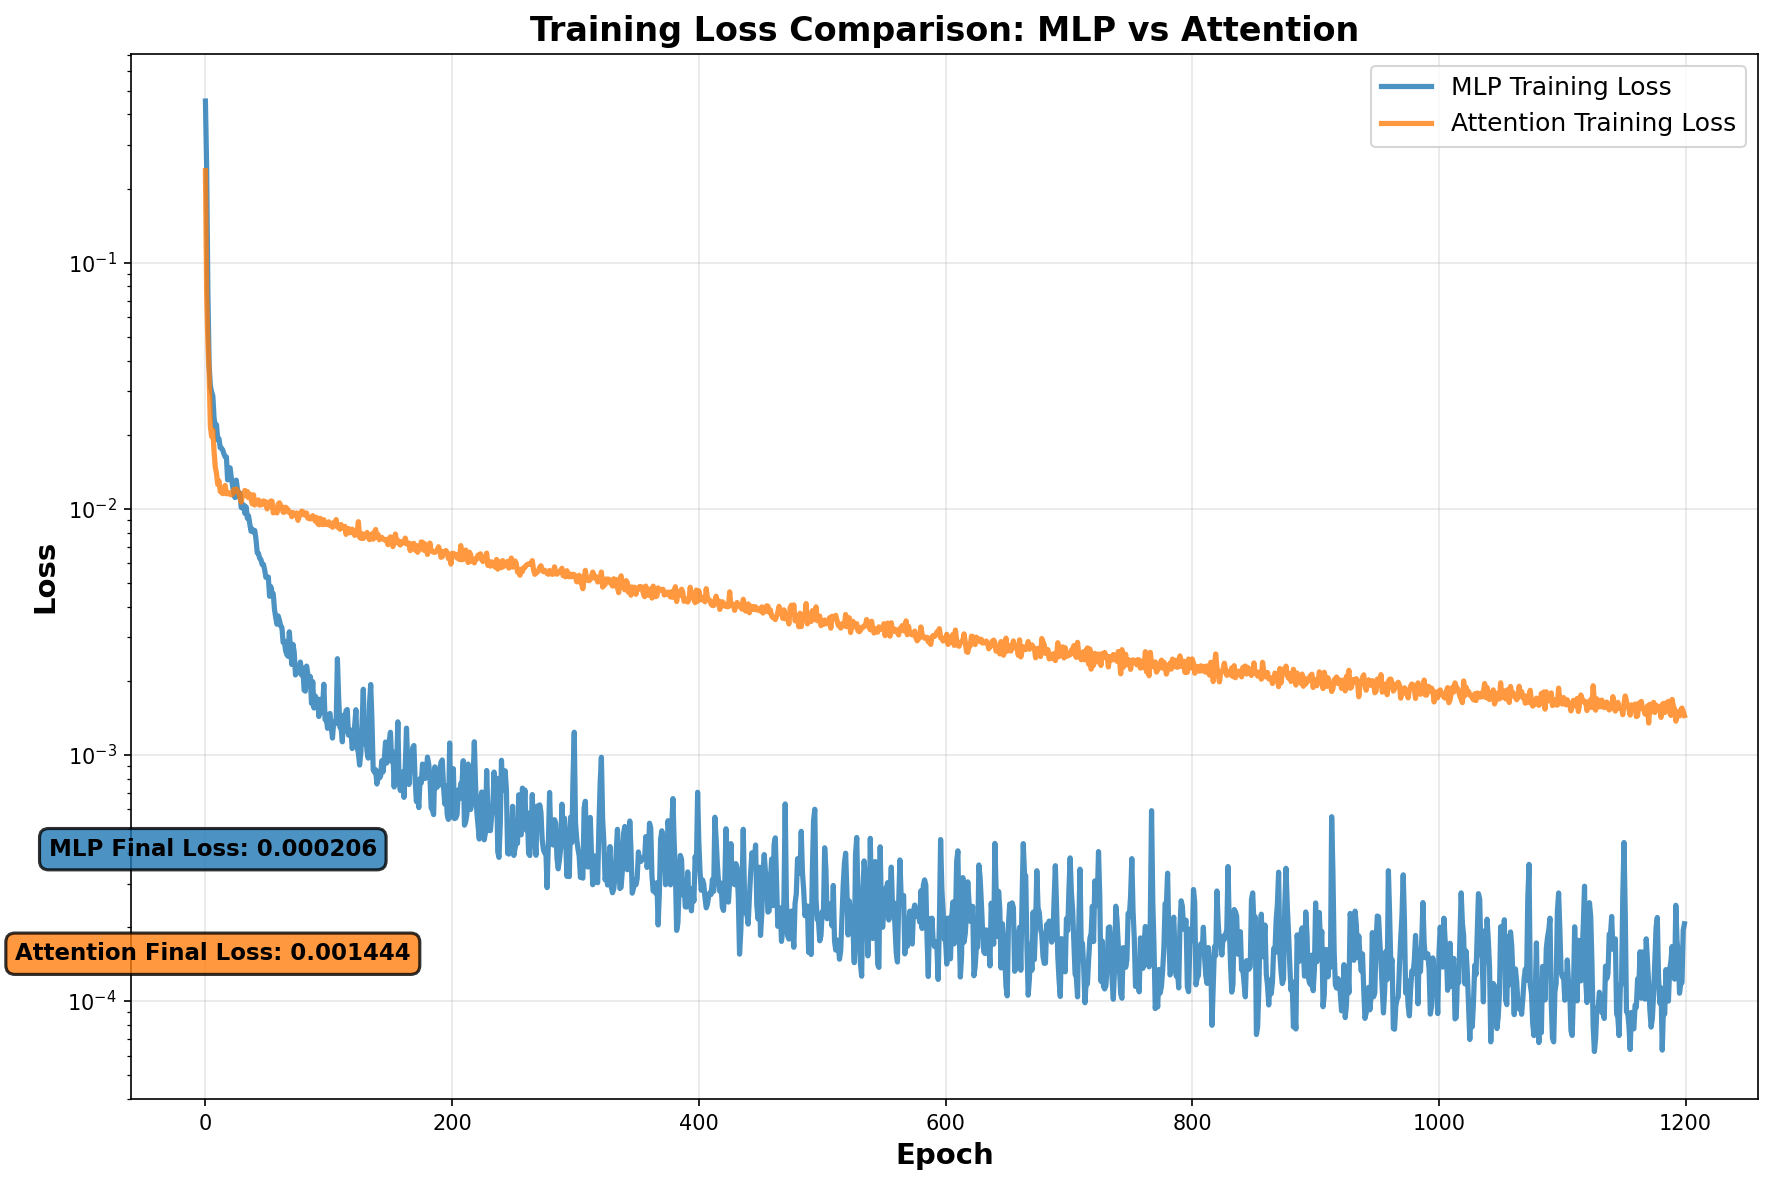

MLP final Loss: 0.000206
Attention final Loss: 0.001444


In [56]:
plot_training_losses(mlp_losses, attn_losses, plotname='losses_mlp_vs_attn_best')

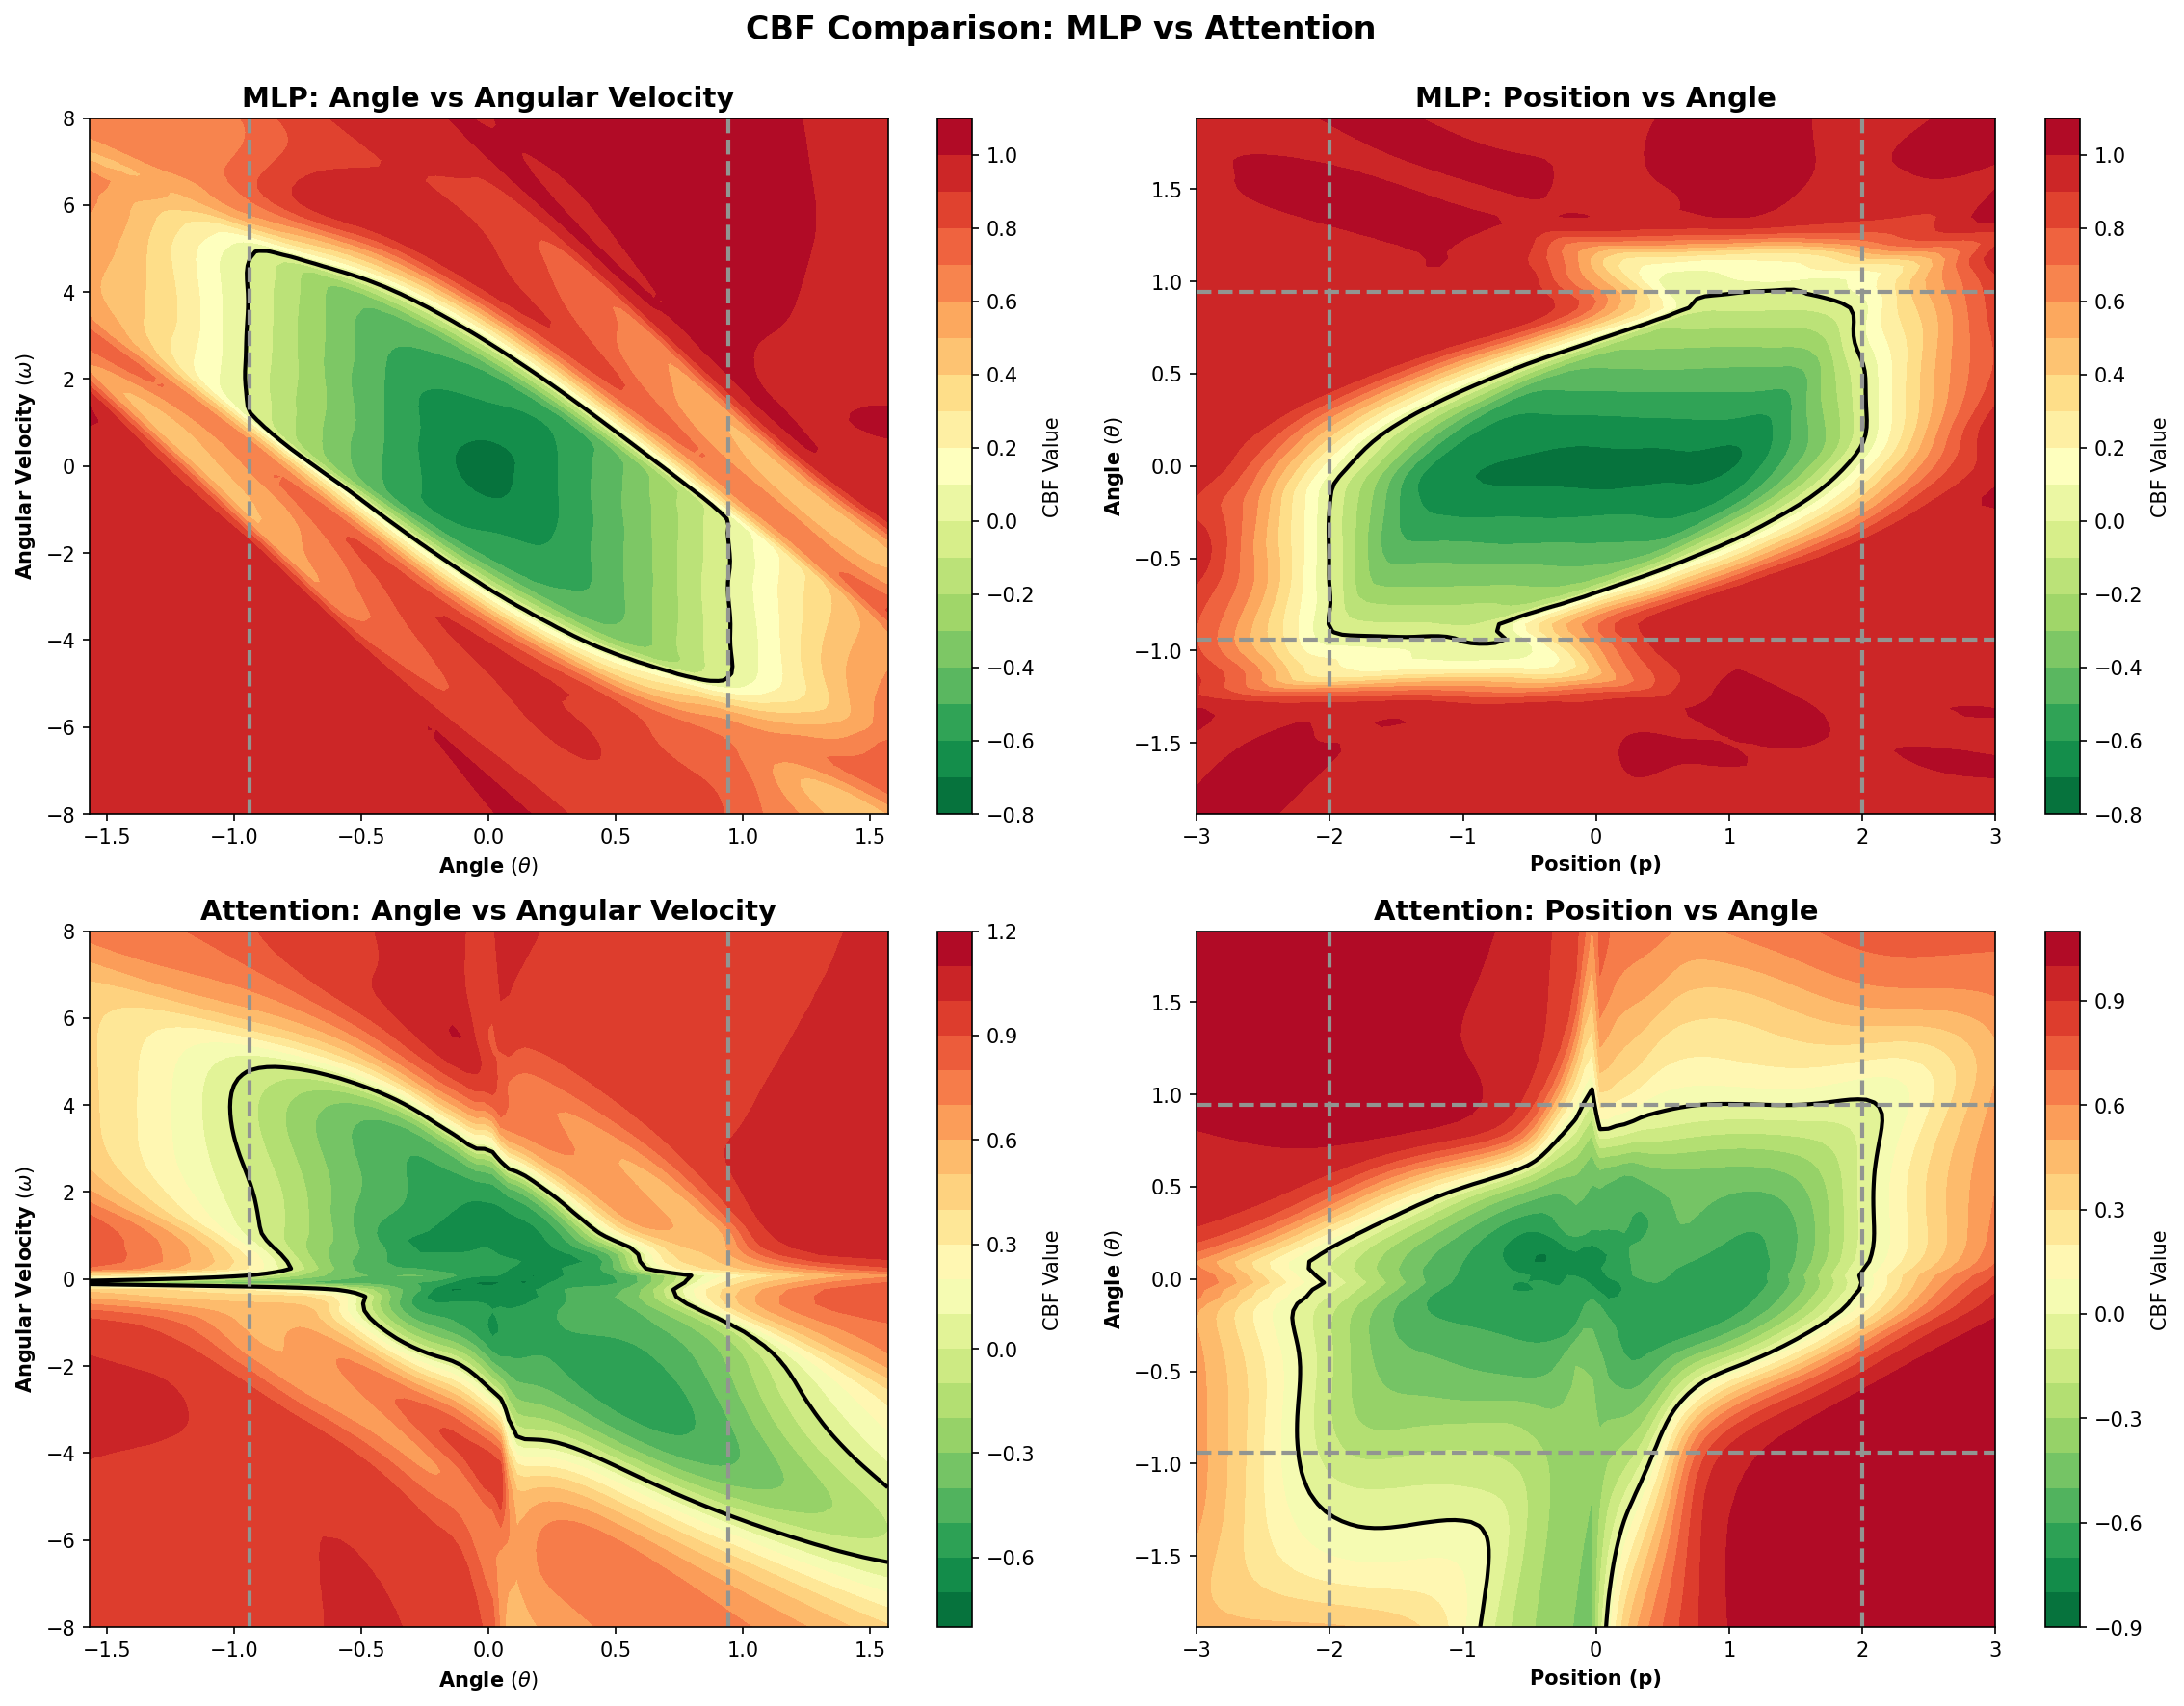

In [57]:

cbf_visual(mlp_params, mlp_apply_fn, 
                          attention_params, attention_apply_fn, system, plotname='cbf_values_mlp_vs._attn_best')

In [58]:
coverage_results = compute_coverage(mlp_params, mlp_apply_fn,
                                             attention_params, attention_apply_fn)


Safe Set Coverage:
Projection                MLP          Attention    Improvement 
------------------------------------------------------------
Angle vs AngVel           30.7%        31.1%        1.4         %
Position vs Angle         63.8%        76.0%        19.1        %
------------------------------------------------------------
AVERAGE                   47.2%        53.6%        13.4        %


In [49]:
class SegwaySafetyFilter:
    def __init__(self, segway, pncbf_params, pncbf_apply_fn, alpha = 1.0):

        self.segway = segway
        self.pncbf_params = pncbf_params
        self.pncbf_apply_fn = pncbf_apply_fn
        self.alpha = alpha

        # control bounds
        self.u_max = segway.umax
        self.u_min = -segway.umax

        self.value_grad_fn = jax.jit(jax.value_and_grad(self.pncbf_fn))

    def pncbf_fn(self, x):

        return self.pncbf_apply_fn(self.pncbf_params, x.reshape(1, -1))[0]
    
    # def filter(self, x, u_nom):
    #     b_value, b_grad = self.value_grad_fn(x)
        
    #     # get system dynamics at the current state
    #     f = self.segway.f(x)
    #     G = self.segway.G(x)

    #     # compute lie derivatives
    #     Lf_B = jnp.dot(b_grad, f)
    #     Lg_B = jnp.dot(b_grad, G)

    #     # QP matrices 
    #     P = jnp.eye(1)
    #     q = -u_nom

    #     # constraints
    #     G_cbf = Lg_B.reshape(1, -1)
    #     h_cbf = jnp.array([-Lf_B - self.alpha * b_value])
        
    #     G_upper = jnp.eye(1)
    #     h_upper = jnp.array([self.u_max])
        
    #     G_lower = -jnp.eye(1)
    #     h_lower = -jnp.array([self.u_min])
        
    #     # combine all constraints
    #     G_ineq = jnp.vstack([G_cbf, G_upper, G_lower])
    #     h_ineq = jnp.concatenate([h_cbf, h_upper, h_lower])

    #     # solves QP to find safe control input
    #     qp_solver = OSQP(tol=1e-6, maxiter=10000)
    #     result, _ = qp_solver.run(params_obj=(P, q), params_eq=None,\
    #                               params_ineq=(G_ineq, h_ineq))
        
    #     # to jax array
    #     u_safe = jnp.asarray(result).reshape(-1)
    #     u_safe = jnp.maximum(jnp.minimum(u_safe, self.u_max), self.u_min)

    #     return u_safe

    def filter(self, x, u_nom):

        # get barrier function value and gradient
        b_value, b_grad = self.value_grad_fn(x)
        
        # get system dynamics
        f = self.segway.f(x)
        G = self.segway.G(x)

        # compute lie derivatives
        Lf_B = jnp.dot(b_grad, f)
        Lg_B = jnp.dot(b_grad, G).flatten()
        
        # calculate the safe limit
        safe_threshold = (-Lf_B - self.alpha * b_value)
        
        # initialize u_safe with nominal control
        u_nom_scalar = u_nom[0]  # extract scalar value
        u_safe = u_nom_scalar
        
        # check cbf constraints
        if Lg_B[0] > 0:
            # If Lg_B > 0, need to be upper-bounded
            u_max_cbf = safe_threshold / Lg_B[0]
            u_safe = jnp.minimum(u_nom_scalar, u_max_cbf)
        elif Lg_B[0] < 0:
            # If Lg_B < 0, need to be lower-bounded
            u_min_cbf = safe_threshold / Lg_B[0]
            u_safe = jnp.maximum(u_nom_scalar, u_min_cbf)
            
        # If Lg_B = 0, control has no effect on CBF --> keep nominal control

        u_safe = jnp.clip(u_safe, self.u_min, self.u_max)
        
        return jnp.array([u_safe])
    
    def __call__(self, x, u_nom):
        return self.filter(x, u_nom)




In [50]:
def simulate_segway(segway, mlp_filter, attention_filter, initial_state, controller, sim_time=5.0, dt=0.01):
    
    # num of simulation steps
    n_steps = int(sim_time / dt)
    
    results = {
        'mlp': {
            'states_safe': np.zeros((n_steps, 4)),
            'states_unsafe': np.zeros((n_steps, 4)),
            'controls_safe': np.zeros((n_steps, 1)),
            'controls_unsafe': np.zeros((n_steps, 1)),
        },
        'attention': {
            'states_safe': np.zeros((n_steps, 4)),
            'states_unsafe': np.zeros((n_steps, 4)),
            'controls_safe': np.zeros((n_steps, 1)),
            'controls_unsafe': np.zeros((n_steps, 1)),
        },
        'times': np.linspace(0, sim_time, n_steps)
    }
    
    # initialize states for both models
    for model_key in ['mlp', 'attention']:
        results[model_key]['states_safe'][0] = initial_state
        results[model_key]['states_unsafe'][0] = initial_state
    
    for i in range(1, n_steps):
        # mlp sim
        x_safe_mlp = results['mlp']['states_safe'][i-1]
        x_unsafe_mlp = results['mlp']['states_unsafe'][i-1]

        
        
        u_nom_mlp = controller(x_safe_mlp)
        u_safe_mlp = mlp_filter(x_safe_mlp, u_nom_mlp)
        results['mlp']['controls_safe'][i-1] = u_safe_mlp
        results['mlp']['controls_unsafe'][i-1] = u_nom_mlp
        
        
        # integrate results
        x_safe_next_mlp = x_safe_mlp + dt * (segway.f(x_safe_mlp) + segway.G(x_safe_mlp) @ u_safe_mlp)
        x_unsafe_next_mlp = x_unsafe_mlp + dt * (segway.f(x_unsafe_mlp) + segway.G(x_unsafe_mlp) @ u_nom_mlp)
        
        results['mlp']['states_safe'][i] = x_safe_next_mlp
        results['mlp']['states_unsafe'][i] = x_unsafe_next_mlp
        
        # attention sim
        x_safe_attn = results['attention']['states_safe'][i-1]
        x_unsafe_attn = results['attention']['states_unsafe'][i-1]
        
        u_nom_attn = controller(x_safe_attn)
        u_safe_attn = attention_filter(x_safe_attn, u_nom_attn)
        results['attention']['controls_safe'][i-1] = u_safe_attn
        results['attention']['controls_unsafe'][i-1] = u_nom_attn
        
        # integrate results
        x_safe_next_attn = x_safe_attn + dt * (segway.f(x_safe_attn) + segway.G(x_safe_attn) @ u_safe_attn)
        x_unsafe_next_attn = x_unsafe_attn + dt * (segway.f(x_unsafe_attn) + segway.G(x_unsafe_attn) @ u_nom_attn)
        
        results['attention']['states_safe'][i] = x_safe_next_attn
        results['attention']['states_unsafe'][i] = x_unsafe_next_attn
    
    # last control inputs
    for model_key, safety_filter in [('mlp', mlp_filter), ('attention', attention_filter)]:
        final_state = results[model_key]['states_safe'][-1]
        results[model_key]['controls_safe'][-1] = safety_filter(final_state, controller(final_state))
        results[model_key]['controls_unsafe'][-1] = controller(results[model_key]['states_unsafe'][-1])
    
    return results

In [51]:
def analyze_safety_violations(results):

    position_limit = 2.0
    angle_limit = 0.3 * np.pi
    
    analysis = {}
    
    for model_key in ['mlp', 'attention']:
        states_safe = results[model_key]['states_safe']
        states_unsafe = results[model_key]['states_unsafe']
        
        # check violations for safe trajectory
        pos_violations_safe = np.sum(np.abs(states_safe[:, 0]) > position_limit)
        angle_violations_safe = np.sum(np.abs(states_safe[:, 1]) > angle_limit)
        
        # check violations for unsafe trajectory
        pos_violations_unsafe = np.sum(np.abs(states_unsafe[:, 0]) > position_limit)
        angle_violations_unsafe = np.sum(np.abs(states_unsafe[:, 1]) > angle_limit)
        
        # maximum constraint violations
        max_pos_violation_safe = np.max(np.abs(states_safe[:, 0])) - position_limit
        max_angle_violation_safe = np.max(np.abs(states_safe[:, 1])) - angle_limit
        
        analysis[model_key] = {
            'safe_trajectory': {
                'position_violations': pos_violations_safe,
                'angle_violations': angle_violations_safe,
                'max_pos_violation': max(0, max_pos_violation_safe),
                'max_angle_violation': max(0, max_angle_violation_safe),
            },
            'unsafe_trajectory': {
                'position_violations': pos_violations_unsafe,
                'angle_violations': angle_violations_unsafe,
            }
        }
    
    return analysis

In [52]:
segway = Segway()

mlp_safety_filter = SegwaySafetyFilter(
    segway,
    mlp_params,
    mlp_apply_fn,
    alpha=1.0
)

attention_safety_filter = SegwaySafetyFilter(
    segway,
    attention_params,
    attention_apply_fn,
    alpha=1.0
)

In [53]:
def controller_test(segway, mlp_filter, attention_filter, plotname):

    scenario = {
        'name': 'Aggressive Destabilizing Controller',
        'initial_state': np.array([1.2, 0.15, 1.5, 0.8]),  
        'controller': lambda state: np.array([4.0 * (state[0] + 2*state[1])]),
        'sim_time': 8.0
    }
    
    print(f"Scenario: {scenario['name']}")
    print(f"Initial state: p={scenario['initial_state'][0]:.1f}, θ={scenario['initial_state'][1]:.2f}, v={scenario['initial_state'][2]:.1f}, ω={scenario['initial_state'][3]:.1f}")
    
    # Run simulation
    results = simulate_segway(
        segway, mlp_filter, attention_filter,
        scenario['initial_state'], scenario['controller'],
        sim_time=scenario['sim_time'], dt=0.01
    )
    
    fig, axes = plt.subplots(3, 2, figsize=(16, 12), dpi=150)
    times = results['times']
    
    # safety constraints
    position_limit = 2.0
    angle_limit = 0.3 * np.pi
    
    #1f77b4 #ff7f0e
    model_names = ['MLP CBF', 'Attention CBF']
    model_keys = ['mlp', 'attention']
    colors = [('#1f77b4', 'red'), ('#ff7f0e', 'red')]
    
    for col, (model_name, model_key, (safe_color, unsafe_color)) in enumerate(zip(model_names, model_keys, colors)):
        states_safe = results[model_key]['states_safe'] 
        states_unsafe = results[model_key]['states_unsafe']
        controls_safe = results[model_key]['controls_safe']
        controls_unsafe = results[model_key]['controls_unsafe']
        
        # pos
        ax = axes[0, col]
        ax.plot(times, states_safe[:, 0], color=safe_color, linewidth=3, label='With Safety Filter', alpha=0.9)
        ax.plot(times, states_unsafe[:, 0], color=unsafe_color, linestyle='--', linewidth=3, label='Without Safety Filter', alpha=0.8)
        ax.axhline(y=position_limit, color='black', linestyle='-', linewidth=2, alpha=0.5, label='Safety Limit')
        ax.axhline(y=-position_limit, color='black', linestyle='-', linewidth=2, alpha=0.5)
        ax.set_ylabel('Position (m)', fontsize=12, fontweight='bold')
        ax.set_title(f'{model_name} - Position Control', fontsize=14, fontweight='bold')
        ax.legend(fontsize=10)
        ax.set_ylim([-3.0, 3.0])
        
        # angle 
        ax = axes[1, col]
        ax.plot(times, states_safe[:, 1], color=safe_color, linewidth=3, alpha=0.9)
        ax.plot(times, states_unsafe[:, 1], color=unsafe_color, linestyle='--', linewidth=3, alpha=0.8)
        ax.axhline(y=angle_limit, color='black', linestyle='-', linewidth=2, alpha=0.5)
        ax.axhline(y=-angle_limit, color='black', linestyle='-', linewidth=2, alpha=0.5)
        ax.set_ylabel('Angle (rad)', fontsize=12, fontweight='bold')
        ax.set_title(f'{model_name} - Angle Control', fontsize=14, fontweight='bold')
        
        # control inputs
        ax = axes[2, col]
        ax.plot(times, controls_safe.flatten(), color=safe_color, linewidth=3, alpha=0.9)
        ax.plot(times, controls_unsafe.flatten(), color=unsafe_color, linestyle='--', linewidth=3, alpha=0.8)
        ax.set_ylabel('Control Input (N)', fontsize=12, fontweight='bold')
        ax.set_xlabel('Time (s)', fontsize=12, fontweight='bold')
        ax.set_title(f'{model_name} - Control Signal', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    
    plt.savefig(plotname + '.png', format='png', dpi=300, bbox_inches='tight')
    plt.savefig(plotname + '.eps', format='eps', bbox_inches='tight')
    plt.show()
    
    # quantitative res
    analysis = analyze_safety_violations(results)
    print("\n" + "="*60)
    
    for model_key in ['mlp', 'attention']:
        model_name = 'MLP CBF' if model_key == 'mlp' else 'Attention CBF'
        safe_stats = analysis[model_key]['safe_trajectory']
        unsafe_stats = analysis[model_key]['unsafe_trajectory']
        
        print(f"\n{model_name}:")
        print(f"-------with safety filter:")
        print(f"position violations: {safe_stats['position_violations']}")
        print(f"angle violations: {safe_stats['angle_violations']}")
        print(f"max position violation: {safe_stats['max_pos_violation']:.4f} m")
        print(f"max angle violation: {safe_stats['max_angle_violation']:.4f} rad")
        
        print(f"-------without safety filter:")
        print(f"position violations: {unsafe_stats['position_violations']}")
        print(f"angle violations: {unsafe_stats['angle_violations']}")
    
    # compute improvmt
    mlp_total_violations = analysis['mlp']['safe_trajectory']['position_violations'] + analysis['mlp']['safe_trajectory']['angle_violations']
    attn_total_violations = analysis['attention']['safe_trajectory']['position_violations'] + analysis['attention']['safe_trajectory']['angle_violations']
    
    print(f"\nViolation counts:")
    print(f"  mlp cbf total violations: {mlp_total_violations}")
    print(f"  attention cbf total violations: {attn_total_violations}")
    
    if attn_total_violations < mlp_total_violations:
        improvmt = ((mlp_total_violations - attn_total_violations) / max(mlp_total_violations, 1)) * 100
        print(f"attention cbf shows {improvmt:.1f}% fewer violations!")
    elif mlp_total_violations < attn_total_violations:
        improvmt = ((attn_total_violations - mlp_total_violations) / max(attn_total_violations, 1)) * 100
        print(f"mlp cbf shows {improvmt:.1f}% fewer violations!")
    else:
        print(f"equal performance")
    
    print("\n" + "="*60)
    
    return results

Scenario: Aggressive Destabilizing Controller
Initial state: p=1.2, θ=0.15, v=1.5, ω=0.8


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


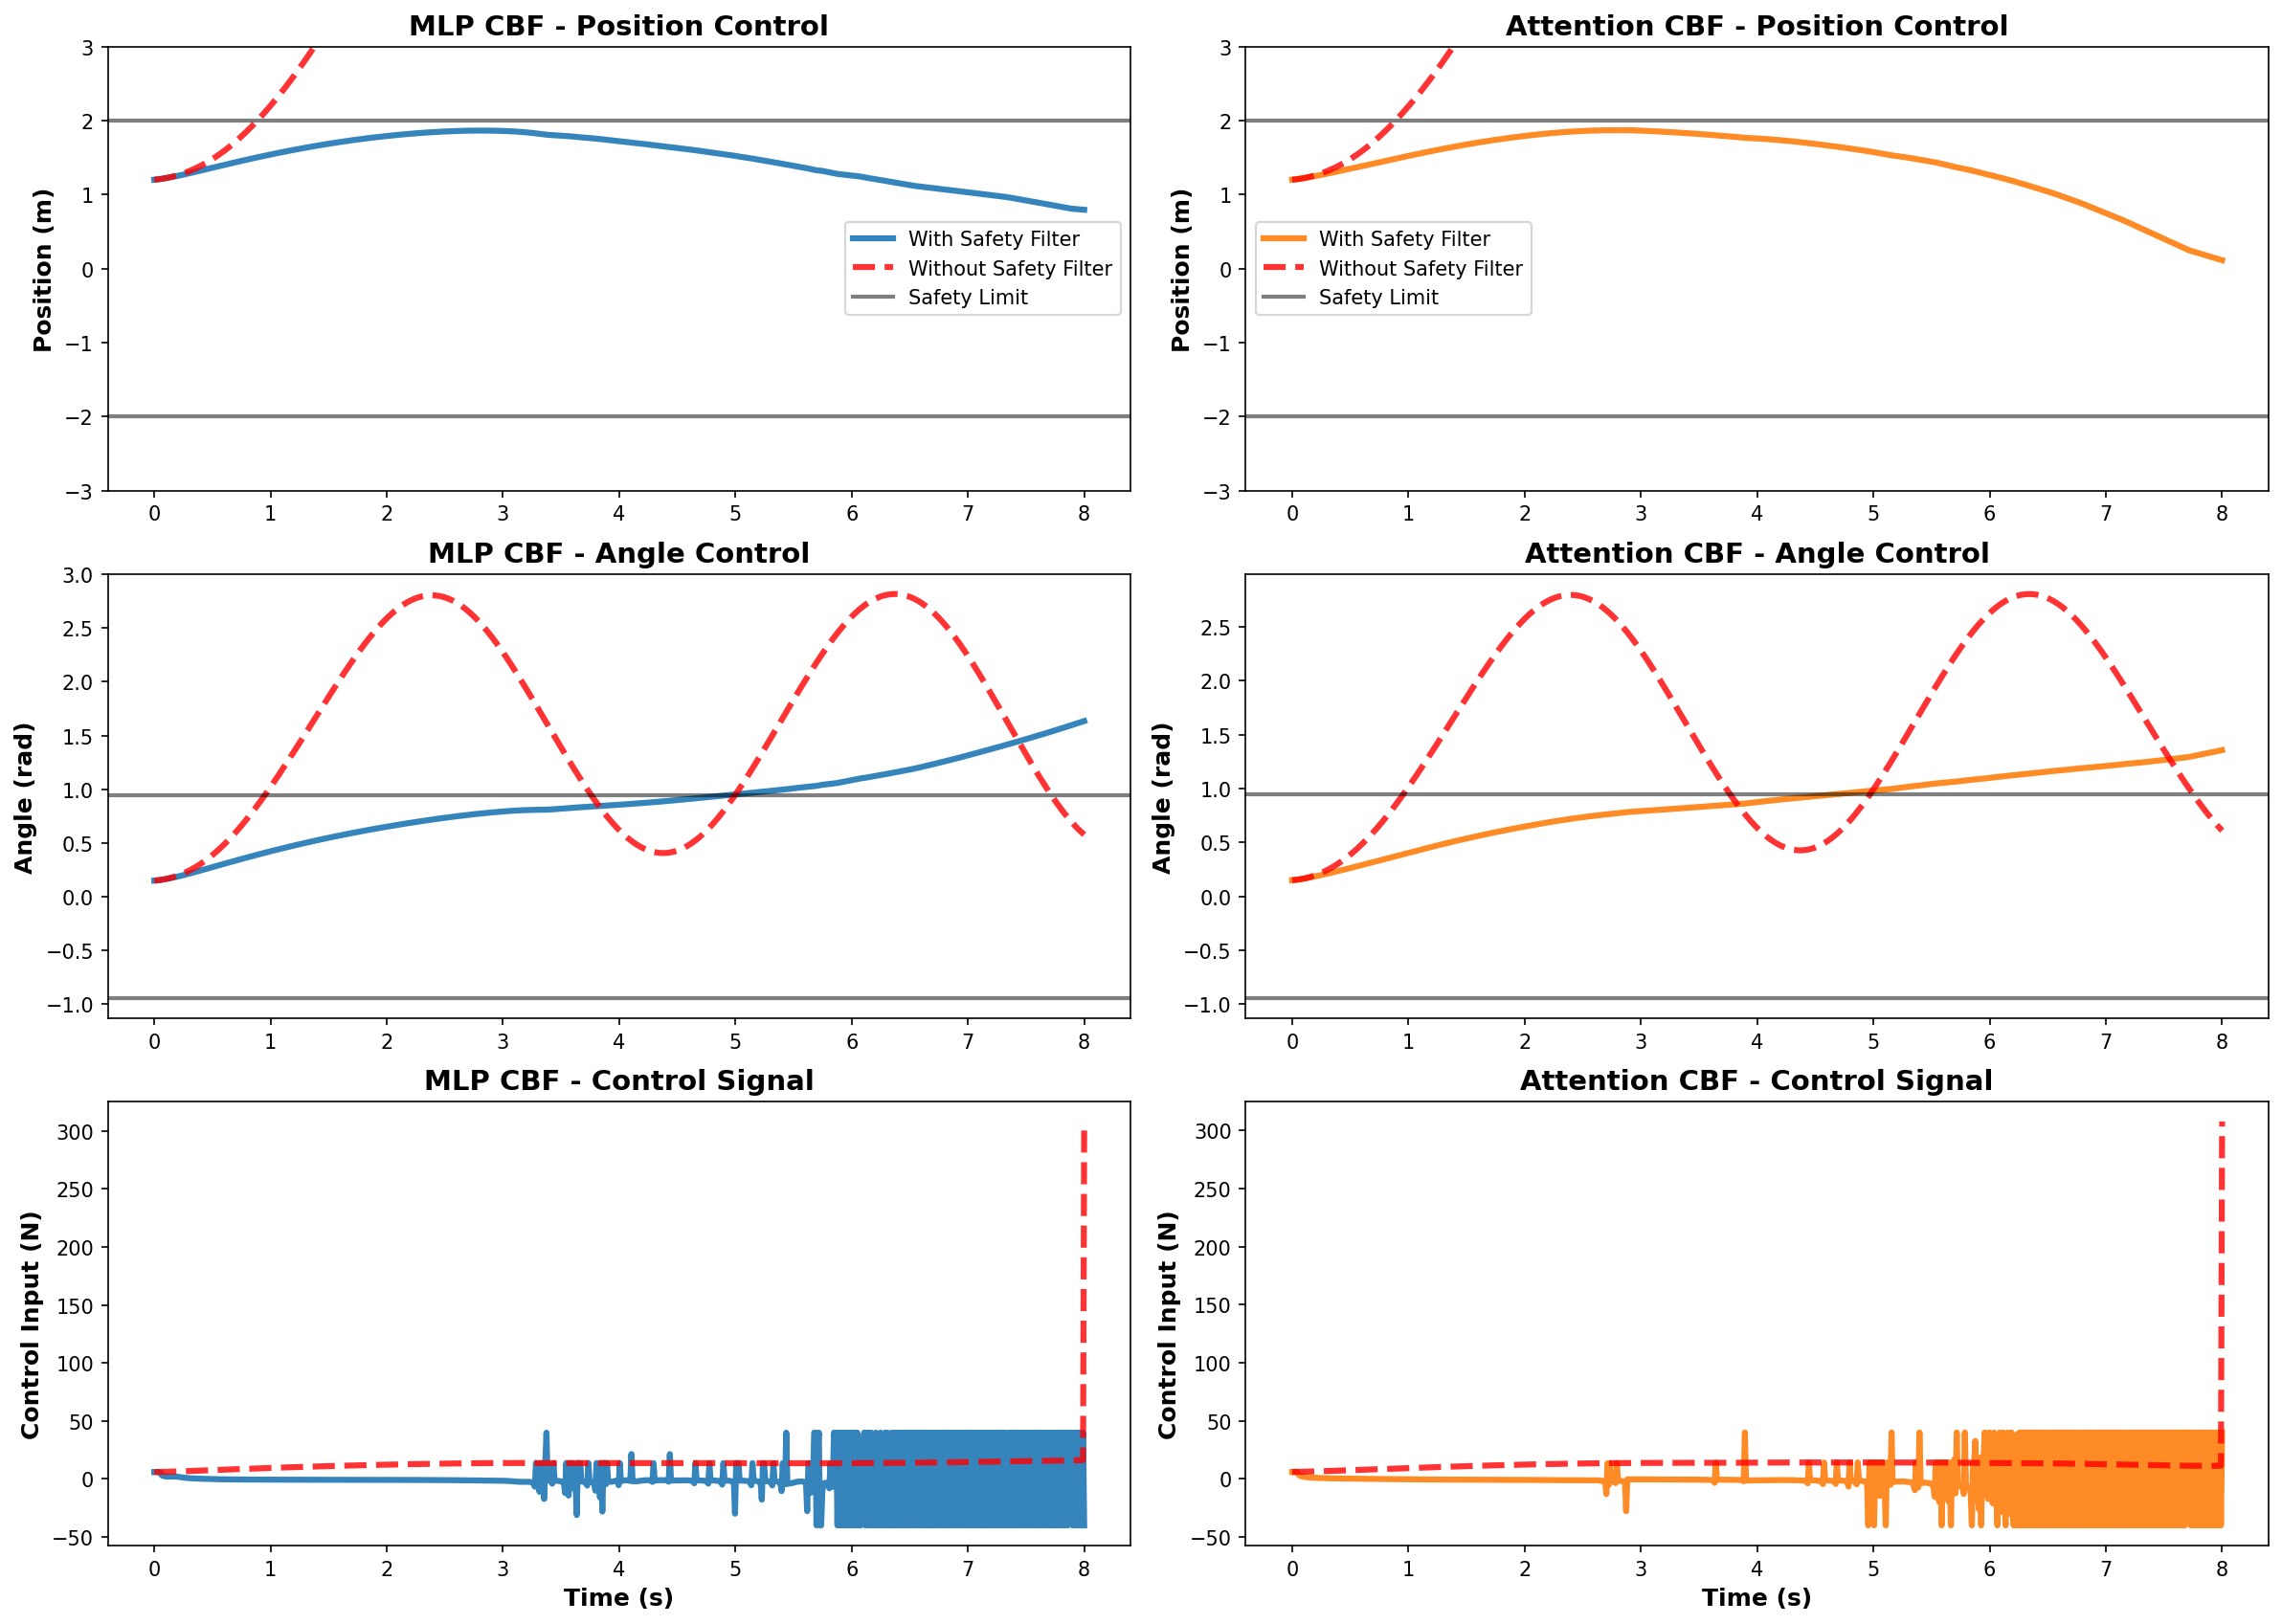



MLP CBF:
-------with safety filter:
position violations: 0
angle violations: 309
max position violation: 0.0000 m
max angle violation: 0.6924 rad
-------without safety filter:
position violations: 711
angle violations: 553

Attention CBF:
-------with safety filter:
position violations: 0
angle violations: 337
max position violation: 0.0000 m
max angle violation: 0.4133 rad
-------without safety filter:
position violations: 711
angle violations: 559

Violation counts:
  mlp cbf total violations: 309
  attention cbf total violations: 337
mlp cbf shows 8.3% fewer violations!



In [59]:
results = controller_test(segway, mlp_safety_filter, attention_safety_filter, plotname='control_test_mlp_vs._attn_best')